# Air Passenger Case Study

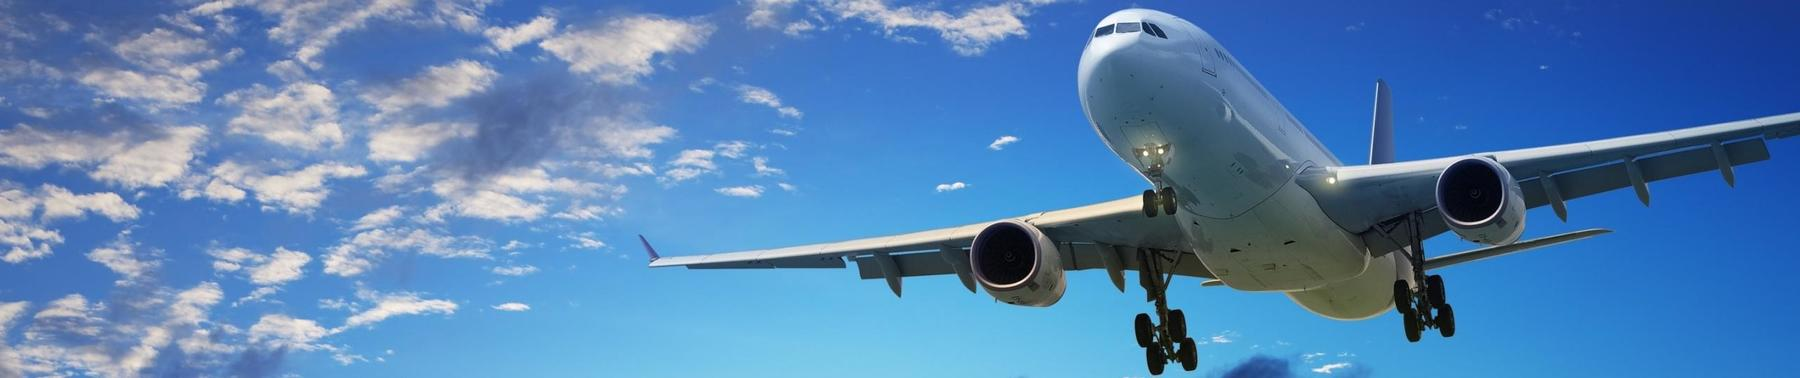

## Importing libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Reading the data 
df=pd.read_csv('/content/drive/MyDrive/AirPassengers.csv')

In [16]:
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [18]:
# convert the month column data type into datetime from object

df['Month']=pd.to_datetime(df['Month'])

In [19]:
# renaming the column name

df.rename({'#Passengers':'num_passengers'},axis=1,inplace=True)

In [20]:
df.head()

,Month,num_passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [21]:
# set Month column as index
df_new=df.copy()
df_new=df_new.set_index('Month')
df_new.head()

,num_passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Visualization fo data

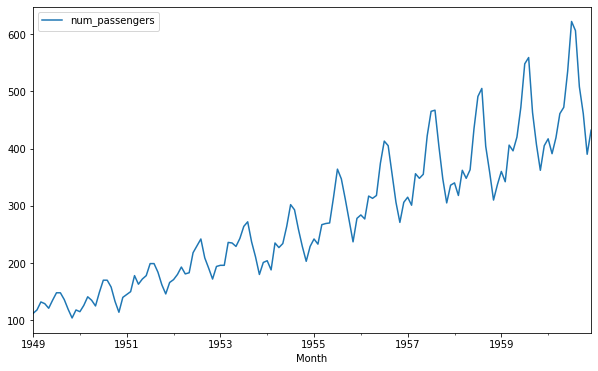

In [22]:
df_new.plot()

## Decompose the time series data into trends, seasonality and residual

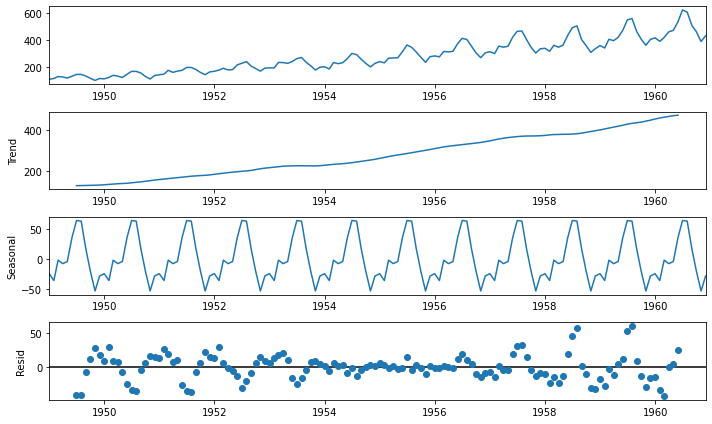

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df_new,model='additive')

from pylab import rcParams
rcParams['figure.figsize']=10,6
fig=result.plot()

## Check whether the dasta is stationary or not 
- we can ckeck the mean and standard deviation of data

- 1. mean should be constant 
- 2. standard deviation should be constant

- We have adfuller test to check whether the data is stationary or not

# Adfuller test
- we will create hypothesis and test the  hypothesis
- H0 : Data is not stationary
- H1 : Data is stationary
- Now claculate the probability value
- If p>0.05 : Accept the null hypothesis(H0)
- If p<0.05 : Reject the null hypothesis

In [24]:
# use dicky fuller test
from statsmodels.tsa.stattools import adfuller

def adfuler(data):
  result=adfuller(data)
  labels=['ADF test statistic','p-value','#lags used','Number of observations used']
  for value, label in zip(result,labels):
    print(label + " : "+ str(value))
  if result[1]<0.05:
    print('Reject the null hypothesis, it means data is  stationary')
  else:
     print('Fail to reject  the null hypothesis, it means data is not stationary')
    
      


adfuler(df_new)

ADF test statistic : 0.8153688792060472
p-value : 0.991880243437641
#lags used : 13
Number of observations used : 130
Fail to reject  the null hypothesis, it means data is not stationary


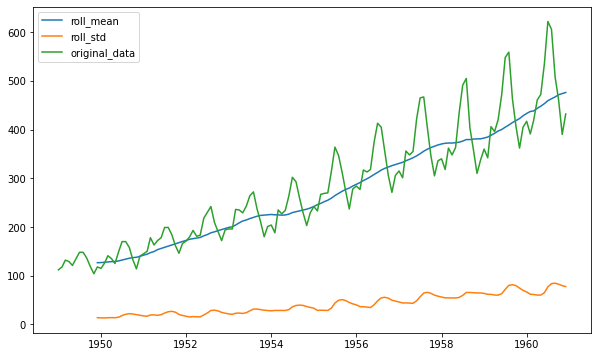

In [25]:
# check the rolling mean and standard deviation
window=12
roll_mean=df_new.rolling(window=12).mean()

roll_std=df_new.rolling(window=12).std()


# plot the graph

plt.plot(roll_mean,label='roll_mean')
plt.plot(roll_std,label='roll_std')
plt.plot(df_new, label='original_data')
plt.legend()

## Handling the non stationarity
- To make the data stationary we do differencing



In [26]:
# differencing

df_new['first_difference']=df_new['num_passengers']-df['num_passengers'].shift(1)



In [27]:
# seasonal differencing

df_new['seasnoal_difference']=df_new['num_passengers']-df_new['num_passengers'].shift(12)

In [28]:
df_new.head(14)

,num_passengers,first_difference,seasnoal_difference
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,NaN,NaN
1949-07-01,148,NaN,NaN
1949-08-01,148,NaN,NaN
1949-09-01,136,NaN,NaN


In [29]:
# now check the stationarity in data

adfuler(df_new['seasnoal_difference'].iloc[12:])

ADF test statistic : -3.383020726492481
p-value : 0.011551493085514952
#lags used : 1
Number of observations used : 130
Reject the null hypothesis, it means data is  stationary


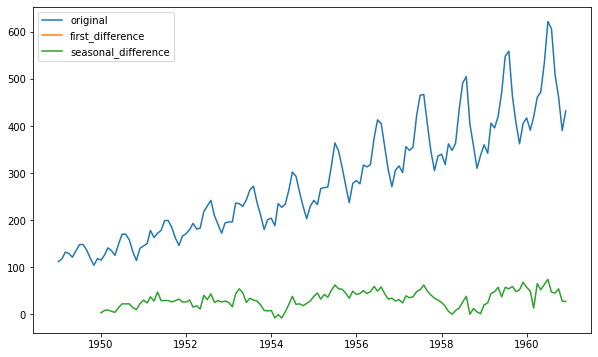

In [30]:
# plot the graph
plt.plot(df_new['num_passengers'],label='original')
plt.plot(df_new['first_difference'],label='first_difference')
plt.plot(df_new['seasnoal_difference'],label='seasonal_difference')
plt.legend()

# ARIMA 
- ARIMA has three componets AutoRegression (p), Differencing(d), MovingAverage(q)
- We have to find out these p,d,q values 
- p value can decided by using Partil Auto Correlation gaph (PACF)
- q value can be decided using Auto correlationg graph (ACF)
- d is decided by number of differencing we are doing

### PACF and ACF

In [31]:
# importing the acf and pacf

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

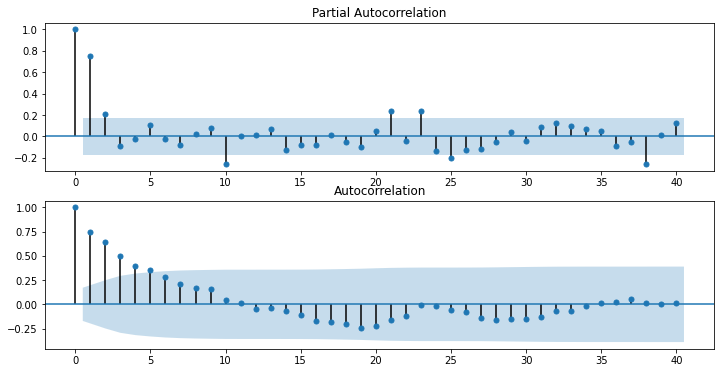

In [32]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot(211)
plot_pacf(df_new['seasnoal_difference'].iloc[13:],lags=40,ax=ax1)
ax2=fig.add_subplot(212)
plot_acf(df_new['seasnoal_difference'].iloc[13:],lags=40,ax=ax2);

- From the above conclusion we can take the p,d,d values 
- p=2, d=1, q=4

In [33]:
# p=2,d=1,q=4

# import ARIMA
from statsmodels.tsa.arima_model import ARIMA

In [34]:
model=ARIMA(df_new['num_passengers'],order=(2,1,4))
model_fit=model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

In [35]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.num_passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -661.292
Method:                       css-mle   S.D. of innovations             23.715
Date:                Sat, 04 Feb 2023   AIC                           1338.585
Time:                        13:47:27   BIC                           1362.288
Sample:                    02-01-1949   HQIC                          1348.216
                         - 12-01-1960                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.6854      0.134     19.981      0.000       2.422       2.949
ar.L1.D.num_passengers     0.9143      0.082     11.141      0.000       0.753       1.075
ar.L2.D.num_passengers    -0.7710      0.080     -9.638      0.000      -0.928      -0.614
ma.L1.D.num_passengers    -0.8357      0.101     -8.269      0.000      -1.034      -0.638
ma.L2.D.num_passengers     0.3272      0.122      2.691      0.007       0.089       0.565
ma.L3.D.num_passengers     0.3086      0.114      2.699      0.007       0.084       0.533
ma.L4.D.num_passengers    -0.8000      0.079    -10.112      0.000      -0.955      -0.645
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5929           -0.9723j            1.1388           -0.1628
AR.2            0.5929           +0.9723j            1.1388            0.1628
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2            0.3179           -0.9481j            1.0000           -0.1985
MA.3            0.3179           +0.9481j            1.0000            0.1985
MA.4           -1.2500           -0.0000j            1.2500           -0.5000
-----------------------------------------------------------------------------
"""

In [36]:
# do forecasting
df_new['forecast']=model_fit.predict(start=120,end=144,dynamic=True)

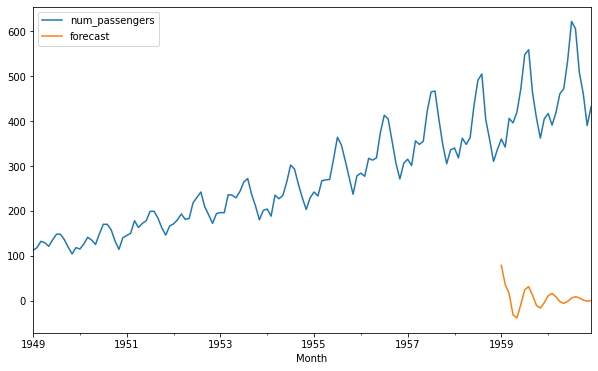

In [37]:
#ploting the graph

df_new[['num_passengers','forecast']].plot()

- Data has seasnality so ARIMA is not working well
- For seasonality we have SARIMAX

# SARIMAX
- The data set has yearly seasonality 
- We use SARMAX to handle seasonality in data  

In [38]:
# import sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

srmx_model=SARIMAX(df_new['num_passengers'],order=(2,1,4),seasonal_order=(1,1,4,12))
srmx_model_fit=srmx_model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
srmx_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     num_passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 4)x(1, 1, 4, 12)   Log Likelihood                -492.435
Date:                            Sat, 04 Feb 2023   AIC                           1008.870
Time:                                    13:47:46   BIC                           1043.372
Sample:                                01-01-1949   HQIC                          1022.890
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0185      0.083    -12.221      0.000      -1.182      -0.855
ar.L2         -0.9160      0.083    -11.070      0.000      -1.078      -0.754
ma.L1          0.6155      0.128      4.810      0.000       0.365       0.866
ma.L2          0.5531      0.152      3.646      0.000       0.256       0.851
ma.L3         -0.4095      0.101     -4.053      0.000      -0.607      -0.211
ma.L4         -0.1687      0.125     -1.350      0.177      -0.414       0.076
ar.S.L12       0.8488      0.234      3.628      0.000       0.390       1.307
ma.S.L12      -1.3417      1.361     -0.986      0.324      -4.010       1.326
ma.S.L24       0.4920      0.996      0.494      0.621      -1.459       2.443
ma.S.L36       0.0733      0.434      0.169      0.866      -0.778       0.925
ma.S.L48       0.1522      0.457      0.333      0.739      -0.744       1.048
sigma2        83.6013    135.087      0.619      0.536    -181.164     348.366
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 2.72
Prob(Q):                              0.76   Prob(JB):                         0.26
Heteroskedasticity (H):               2.39   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
# do forecasting using SARIMAX
df_new['new_forecast']=srmx_model_fit.predict(start=120,end=144,dynamic=True)

In [58]:
df_new[['num_passengers','new_forecast']].iloc[120:144]

,num_passengers,new_forecast
Month,,
1959-01-01,360,356.022638
1959-02-01,342,327.972551
1959-03-01,406,377.059536
1959-04-01,396,376.144880
1959-05-01,420,383.190023
1959-06-01,472,460.291538
1959-07-01,548,525.940844
1959-08-01,559,523.661658
1959-09-01,463,431.826635


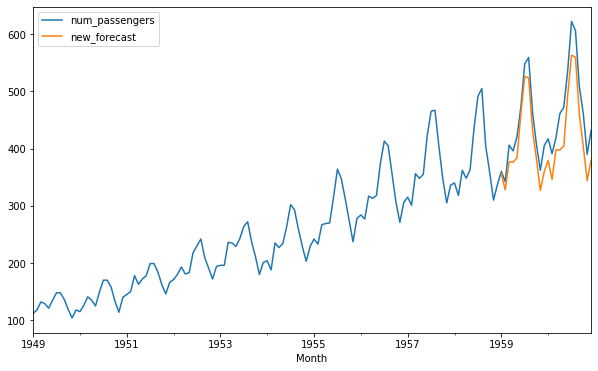

In [41]:
# plot the graph
df_new[['num_passengers','new_forecast']].plot()

- Now we can see SARIMAX is giving us the good prediction

In [74]:
# calculate the performance 
from sklearn.metrics import mean_squared_error,mean_absolute_error

def performance(y,y_hat):
  mse=mean_squared_error(y,y_hat)
  mae=mean_absolute_error(y,y_hat)
  rmse=np.sqrt(mse)
  print('mse', mse)
  print('mae', mae)
  print('rmse',rmse)
  


In [75]:
y=df_new['num_passengers'].iloc[120:144]
y_hat=df_new['new_forecast'].iloc[120:144]

performance(y,y_hat)

mse 1672.2676979105006
mae 37.411891061452216
rmse 40.893369852709625


## Applying fbprophet

In [42]:
df

,Month,num_passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [43]:
# rename the columns 
df1=df.copy()
df1['ds']=df1['Month']
df1['y']=df1['num_passengers']

In [44]:
# drop the month and num_passengers column

df1=df1.drop(columns=['Month','num_passengers'])

In [45]:
df1.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [46]:
# import the prophet

from prophet import Prophet

In [47]:
# initialize the model

model=Prophet()

In [48]:
# train the model
model.fit(df1)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4vzl_30d/tolr5mxm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4vzl_30d/9gvlzrei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80123', 'data', 'file=/tmp/tmp4vzl_30d/tolr5mxm.json', 'init=/tmp/tmp4vzl_30d/9gvlzrei.json', 'output', 'file=/tmp/tmp4vzl_30d/prophet_modelt1y_8ljt/prophet_model-20230204134747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:47:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [49]:
model.component_modes

{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [50]:
# make future dates 
future_dates=model.make_future_dataframe(periods=365)

In [51]:
future_dates.head()

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01


In [52]:
# prediction
prediction=model.predict(future_dates)

In [53]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,107.398252,56.292939,115.098315,107.398252,107.398252,-21.393308,-21.393308,-21.393308,-21.393308,-21.393308,-21.393308,0.0,0.0,0.0,86.004944
1,1949-02-01,109.544420,51.320266,107.835356,109.544420,109.544420,-30.060620,-30.060620,-30.060620,-30.060620,-30.060620,-30.060620,0.0,0.0,0.0,79.483800
2,1949-03-01,111.482895,83.045540,140.964171,111.482895,111.482895,-0.469818,-0.469818,-0.469818,-0.469818,-0.469818,-0.469818,0.0,0.0,0.0,111.013077
3,1949-04-01,113.629063,78.368127,137.867548,113.629063,113.629063,-4.917723,-4.917723,-4.917723,-4.917723,-4.917723,-4.917723,0.0,0.0,0.0,108.711340
4,1949-05-01,115.706000,85.085548,140.327865,115.706000,115.706000,-3.618250,-3.618250,-3.618250,-3.618250,-3.618250,-3.618250,0.0,0.0,0.0,112.087749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,1961-11-27,520.934753,470.436730,527.576109,520.307402,521.408291,-21.361219,-21.361219,-21.361219,-21.361219,-21.361219,-21.361219,0.0,0.0,0.0,499.573534
505,1961-11-28,521.035587,469.774885,526.825409,520.406502,521.514849,-23.063456,-23.063456,-23.063456,-23.063456,-23.063456,-23.063456,0.0,0.0,0.0,497.972130
506,1961-11-29,521.136420,466.793794,524.643475,520.505602,521.621408,-25.486988,-25.486988,-25.486988,-25.486988,-25.486988,-25.486988,0.0,0.0,0.0,495.649432
507,1961-11-30,521.237254,463.498751,519.881051,520.604702,521.726238,-28.590291,-28.590291,-28.590291,-28.590291,-28.590291,-28.590291,0.0,0.0,0.0,492.646963


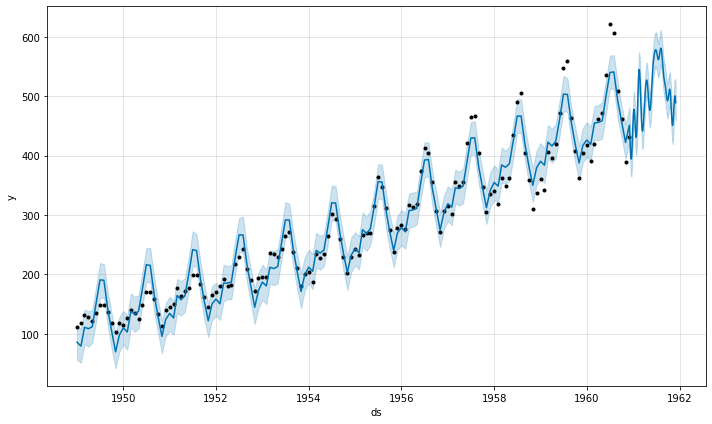

In [54]:
# plot the prediction
model.plot(prediction);

In [77]:
# check the performance
y=df['num_passengers'].iloc[120:144]
y_hat=prediction['yhat'].iloc[120:144]

# calling the performance function
performance(y,y_hat)

mse 1075.8734890490643
mae 26.090941341382905
rmse 32.800510499824


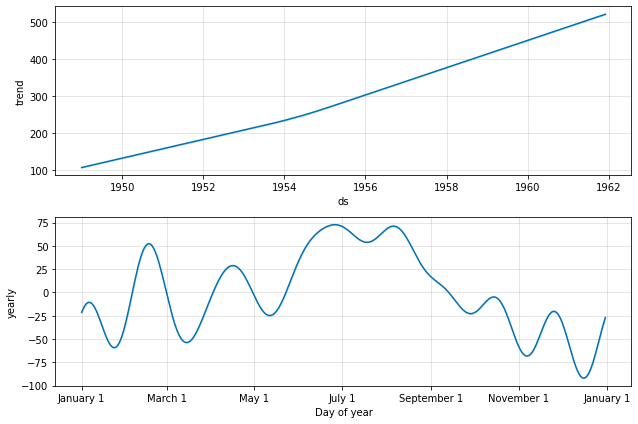

In [55]:
# plot the components like trend and seasonality

model.plot_components(prediction);